In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from tqdm import tqdm
import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os
import random
from meteostat import Point, Daily

In [8]:
def set_all_seeds(seed=22):
    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    
set_all_seeds()
seed=22

In [63]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Вычисляет расстояние между двумя точками на поверхности Земли в метрах, используя формулу гаверсинуса.
    """
    R = 6371000  # радиус Земли в метрах
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = phi2 - phi1
    d_lambda = np.radians(lon2 - lon1)

    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    return 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Вычисляет азимут между двумя точками (в градусах от северного направления).
    """
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_lambda = np.radians(lon2 - lon1)
    x = np.sin(d_lambda) * np.cos(phi2)
    y = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(d_lambda)
    return (np.degrees(np.arctan2(x, y)) + 360) % 360

def transform_geospatial_features(df, lat_col='latitude', lon_col='longitude',
                                  reference_points=None, competitor_coords=None, 
                                  grid_size=0.1, n_clusters=5, eps=0.01, min_samples=5, prefix='start', seed=42):
    """
    Преобразует географические данные с добавлением новых признаков.
    """
    
    # 1. Признаки расстояния
    if reference_points:
        for name, ref_point in reference_points.items():
            df[f'dist_to_{name}_' + prefix] = df.apply(
                lambda row: haversine(row[lat_col], row[lon_col], ref_point[0], ref_point[1]), axis=1
            )

    if competitor_coords:
        df['dist_to_nearest_competitor_' + prefix] = df.apply(
            lambda row: min(haversine(row[lat_col], row[lon_col], comp[0], comp[1]) for comp in competitor_coords), axis=1
        )
    print(1)
    # 2. Кластеризация
    #coords = df[[lat_col, lon_col]].to_numpy()
    #kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    #df['kmeans_cluster_' + prefix] = kmeans.fit_predict(coords)

    #dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    #df['dbscan_cluster_' + prefix] = dbscan.fit_predict(coords)
    #print(2)
    # 3. Признаки сетки
    #df['grid_cell_' + prefix] = df.apply(
    #    lambda row: (int(row[lat_col] // grid_size), int(row[lon_col] // grid_size)), axis=1
    #)

    # 4. Признаки направления
    if reference_points:
        first_ref_point = list(reference_points.values())[0]
        df['azimuth_to_first_reference_' + prefix] = df.apply(
            lambda row: calculate_bearing(row[lat_col], row[lon_col], first_ref_point[0], first_ref_point[1]), axis=1
        )
    print(3)
    # Векторные признаки
    df['lat_cos_' + prefix] = np.cos(np.radians(df[lat_col]))
    df['lat_sin_' + prefix] = np.sin(np.radians(df[lat_col]))
    df['lon_cos_' + prefix] = np.cos(np.radians(df[lon_col]))
    df['lon_sin_' + prefix] = np.sin(np.radians(df[lon_col]))

    # Полярные координаты
    df['polar_lat_' + prefix] = np.radians(df[lat_col])
    df['polar_lon_' + prefix] = np.radians(df[lon_col])
    print(4)
    return df


In [ ]:
ref_point = {'lc': (51.5085300, 0.12574)}

In [101]:
def preproc(train):
    train = train.drop(columns=['fullAddress', 'ID', 'postcode', 'outcode', 'country'])
    for x in train.select_dtypes(object).columns.tolist():
        train[x] = train[x].fillna(train[x].mode()[0])
    for x in train.select_dtypes(float).columns.tolist():
        train[x] = train[x].fillna(train[x].median())
    train = transform_geospatial_features(train, reference_points=ref_point)
    train['month_cos'] = np.cos(2 * np.pi * train['sale_month'] / 12)
    train['month_sin'] = np.sin(2 * np.pi * train['sale_month'] / 12)
    return train

In [64]:
train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')

In [66]:
train.dtypes

ID                       int64
fullAddress             object
postcode                object
country                 object
outcode                 object
latitude               float64
longitude              float64
bathrooms              float64
bedrooms               float64
floorAreaSqM           float64
livingRooms            float64
tenure                  object
propertyType            object
currentEnergyRating     object
sale_month               int64
sale_year                int64
price                    int64
dtype: object

In [67]:
train = train.drop(columns=['fullAddress', 'ID', 'postcode', 'outcode', 'country'])

In [68]:
for x in train.select_dtypes(object).columns.tolist():
    train[x] = train[x].fillna(train[x].mode()[0])

In [69]:
for x in train.select_dtypes(float).columns.tolist():
    train[x] = train[x].fillna(train[x].median())

In [70]:
train = transform_geospatial_features(train, reference_points=ref_point)

1
3
4


In [78]:
train['month_cos'] = np.cos(2 * np.pi * train['sale_month'] / 12)
train['month_sin'] = np.sin(2 * np.pi * train['sale_month'] / 12)

In [79]:
import matplotlib.pyplot as plt

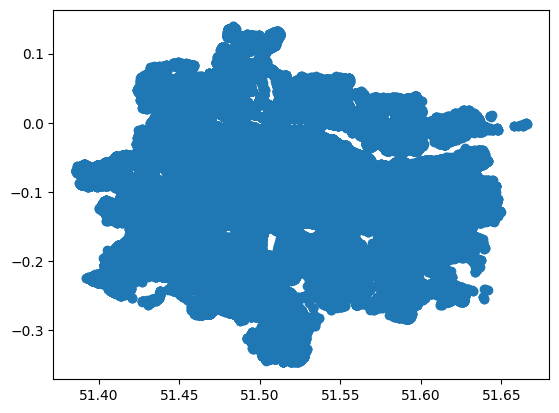

In [80]:
plt.scatter(x=train['latitude'], y=train['longitude'])

In [86]:
cat_feat = train.columns[train.dtypes == object].tolist()

In [87]:
X = train.drop(columns=['price'])
y = train['price']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
train_dataset = catboost.Pool(X_train, y_train, cat_features=cat_feat)
test_dataset = catboost.Pool(X_test, y_test, cat_features=cat_feat)

In [95]:
model_class = catboost.CatBoostRegressor(use_best_model=True, random_state=seed, cat_features=cat_feat)

In [96]:
model_class.fit(train_dataset, eval_set=test_dataset)

Learning rate set to 0.114916
0:	learn: 1232295.1464760	test: 1245989.8785881	best: 1245989.8785881 (0)	total: 70.3ms	remaining: 1m 10s
1:	learn: 1201293.7883534	test: 1216017.3141559	best: 1216017.3141559 (1)	total: 145ms	remaining: 1m 12s
2:	learn: 1173951.2171778	test: 1190353.4937416	best: 1190353.4937416 (2)	total: 212ms	remaining: 1m 10s
3:	learn: 1150893.2202152	test: 1167569.3738859	best: 1167569.3738859 (3)	total: 283ms	remaining: 1m 10s
4:	learn: 1132167.2321765	test: 1150166.9932140	best: 1150166.9932140 (4)	total: 357ms	remaining: 1m 11s
5:	learn: 1113813.4773960	test: 1133751.0418574	best: 1133751.0418574 (5)	total: 425ms	remaining: 1m 10s
6:	learn: 1097702.4300468	test: 1119055.5170051	best: 1119055.5170051 (6)	total: 506ms	remaining: 1m 11s
7:	learn: 1086263.0270278	test: 1108593.5016731	best: 1108593.5016731 (7)	total: 573ms	remaining: 1m 11s
8:	learn: 1076277.0738608	test: 1098447.3966128	best: 1098447.3966128 (8)	total: 639ms	remaining: 1m 10s
9:	learn: 1065630.486637

In [92]:
from sklearn.metrics import mean_absolute_error

In [97]:
mean_absolute_error(y_test, model_class.predict(X_test))

185450.96997606911

In [99]:
model_class = catboost.CatBoostRegressor(random_state=seed, cat_features=cat_feat)

In [100]:
model_class.fit(X, y)

Learning rate set to 0.098945
0:	learn: 1240910.6435069	total: 72.2ms	remaining: 1m 12s
1:	learn: 1213726.0352118	total: 151ms	remaining: 1m 15s
2:	learn: 1190051.5226708	total: 233ms	remaining: 1m 17s
3:	learn: 1168601.3635765	total: 305ms	remaining: 1m 15s
4:	learn: 1150164.2226019	total: 413ms	remaining: 1m 22s
5:	learn: 1132282.4441371	total: 498ms	remaining: 1m 22s
6:	learn: 1118236.5510517	total: 574ms	remaining: 1m 21s
7:	learn: 1104411.7549777	total: 660ms	remaining: 1m 21s
8:	learn: 1092743.5835477	total: 739ms	remaining: 1m 21s
9:	learn: 1083291.8100020	total: 831ms	remaining: 1m 22s
10:	learn: 1074577.7512768	total: 917ms	remaining: 1m 22s
11:	learn: 1065897.0814078	total: 1s	remaining: 1m 22s
12:	learn: 1058532.6008932	total: 1.09s	remaining: 1m 22s
13:	learn: 1052329.5178465	total: 1.18s	remaining: 1m 22s
14:	learn: 1045832.3704092	total: 1.26s	remaining: 1m 23s
15:	learn: 1041441.0796048	total: 1.34s	remaining: 1m 22s
16:	learn: 1034003.3098019	total: 1.42s	remaining: 1m 

In [102]:
test = preproc(test)

1
3
4


In [107]:
pred = model_class.predict(test)

In [108]:
sab = pd.read_csv('sample_submission.csv')

In [110]:
sab['price'] = pred

In [111]:
sab.to_csv(r'answer.csv', index=False)